# Probabilistic Programming 3: variational Bayes

#### Goal 
  - Know what is required to set up a variational Bayesian inference procedure.
  - Learn how to infer the parameters of a Gaussian mixture model using a variational inference procedure.

#### Materials        
  - Mandatory
    - This notebook
    - Lecture notes on latent variable models
  - Optional
    - [Review of latent variable models](https://doi.org/10.1146/annurev-statistics-022513-115657)
    - [Differences between Julia and Matlab / Python](https://docs.julialang.org/en/v1/manual/noteworthy-differences/index.html).

Note that none of the material below is new. The point of the Probabilistic Programming sessions is to solve practical problems so that the concepts from Bert's lectures become less abstract.

In [ ]:
using Pkg; Pkg.activate("../../."); Pkg.instantiate();
using IJulia; try IJulia.clear_output(); catch _ end

In [2]:
using JLD
using Statistics
using LinearAlgebra
using Distributions
using RxInfer
using ColorSchemes
using LaTeXStrings
using Plots
default(label="", grid=false, linewidth=3, margin=10Plots.pt)
include("../scripts/clusters.jl");

## Problem: Stone Tools

Archeologists have asked for your help in analyzing data on tools made of stone. It is believed that primitive humans created tools by striking stones with others. During this process, the stone loses flakes, which have been preserved. The archeologists have recovered these flakes from various locations and time periods and want to know whether this stone tool shaping process has improved over the centuries.

### Data

The data is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/StoneFlakes). Each instance represents summary information of the stone flakes for a particular site. We will be using the attributes _flaking angle_ (FLA) and the _proportion of the dorsal surface worked_ (PROZD) for now.

In [3]:
data = load("../datasets/stone_flakes.jld");

I've done some pre-processing on the data set, namely [z-scoring](https://nl.wikipedia.org/wiki/Z-score) and removing two outliers. This reduces the scale of the attributes which helps numerical stability during optimization. Now let's visualize the data with a scatterplot.

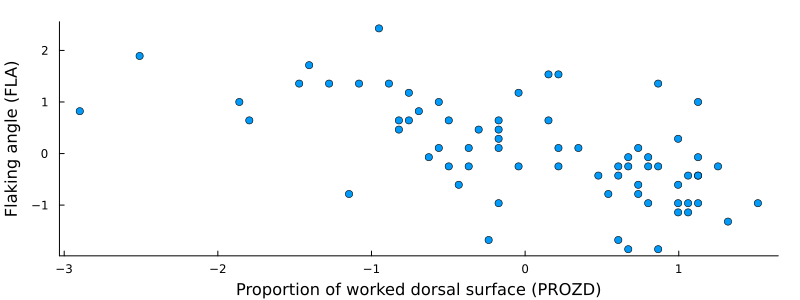

In [4]:
scatter(data["observations"][:,1], 
        data["observations"][:,2], 
        label="", 
        xlabel="Proportion of worked dorsal surface (PROZD)",
        ylabel="Flaking angle (FLA)",
        size=(800,300))

### Model specification

We will be clustering this data with a Gaussian mixture model, to see if we can identify clear types of stone tools. The generative model for a Gaussian mixture consists of:

$$ p(X, z, \pi, \mu, \Lambda) =\ \underbrace{p(X \mid z, \mu, \Lambda)}_{\text{likelihood}}\ \times \ \underbrace{p(z \mid \pi)}_{\text{prior latent variables}} \ \times \ \underbrace{p(\mu \mid \Lambda)\  p(\Lambda)\ p(\pi)}_{\text{prior parameters}}$$

with the likelihood of observation $X_i$ being a Gaussian raised to the power of the latent assignment variables $z$

$$ p(X_i \mid z, \mu, \Lambda) = \prod_{k=1}^{K} \mathcal{N}(X_i \mid \mu_k, \Lambda_k^{-1})^{z_i = k}$$

the prior for each latent variable $z_i$ being a Categorical distribution

$$ p(z_i \mid \pi) = \text{Categorical}(z_i \mid \pi) $$

and priors for the parameters being

$$ \begin{aligned} p(\Lambda_k) =&\ \text{Wishart}(\Lambda_k \mid V_0, n_0) \qquad &\text{for all}\ k , \\ p(\mu_k \mid \Lambda_k) =&\ \mathcal{N}(\mu_k \mid m_0, \Lambda_k^{-1}) \qquad &\text{for all}\ k , \\ p(\pi) =&\ \text{Dirichlet}(\pi \mid a_0) \quad . \end{aligned}$$

We can implement these equations nearly directly in ReactiveMP.

In [5]:
# Data dimensionality
num_features = size(data["observations"],2)

# Sample size
num_samples = size(data["observations"],1)

# Number of mixture components
num_components = 3;

Mixture models can be sensitive to initialization, so we are going to specify the prior parameters explicitly.

In [6]:
# Prior scale matrices
V0 = repeat(diageye(num_features), 1,1,3)

# Prior degrees of freedom 
n0 = num_features

# Prior means
m0 = [ 1.0 0.0 -1.0;
      -1.0 0.0  1.0];

# Prior concentration parameters
a0 = ones(num_components);

Now to specify the full model.

In [7]:
@model function GMM(X, n0, V0, m0, a0, K, N)
    "Bayesian Gaussian mixture model"

    local μ
    local Λ
    
    # Component parameters
    for k in 1:K
        Λ[k] ~ Wishart(n0, V0[:,:,k])
        μ[k] ~ MvNormalMeanPrecision(m0[:,k], Λ[k])
    end
    
    # Mixture weights
    π ~ Dirichlet(a0)
    
    for i in 1:N
        
        # Latent assignment variable
        z[i] ~ Categorical(π)
        
        # Mixture distribution
        X[i] ~ NormalMixture(switch = z[i], m = μ, p = Λ)
        
    end
end

Set up the inference procedure.

In [12]:
# Map data to list of vectors
observations = [data["observations"][i,:] for i in 1:num_samples]

# Initialize variational distributions
init = @initialization begin
    q(π) = Dirichlet(a0)
    q(μ) = [MvNormalMeanCovariance(m0[:,k], diageye(num_features)) for k in 1:num_components]
    q(Λ) = [Wishart(n0, V0[:,:,k]) for k in 1:num_components]
end

# Iterations of variational inference
num_iters = 100

# Variational inference
results = infer(
    model          = GMM(n0=n0, V0=V0, m0=m0, a0=a0, K=num_components, N=num_samples),
    data           = (X = observations,),
    constraints    = MeanField(),
    initialization = init,
    iterations     = num_iters,
    free_energy    = true,
    showprogress   = true,
)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


Inference results:
  Posteriors       | available for (π, μ, Λ, z)
  Free Energy:     | Real[198.944, 197.247, 196.218, 195.341, 194.82, 194.541, 194.341, 194.178, 194.041, 193.924  …  193.448, 193.448, 193.448, 193.448, 193.448, 193.448, 193.448, 193.448, 193.448, 193.448]


Alright, we're done. Let's track the evolution of free energy over iterations.

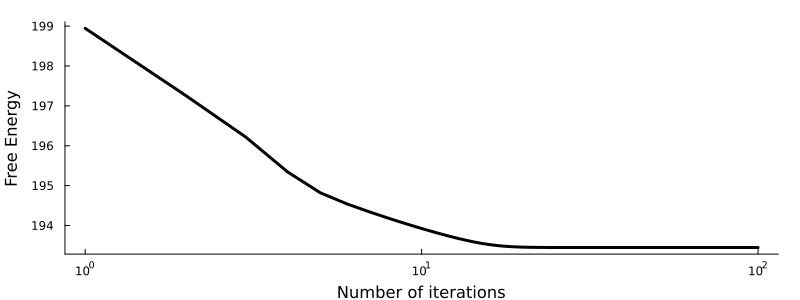

In [13]:
plot(1:num_iters, 
     results.free_energy, 
     color="black", 
     xscale=:log10,
     xlabel="Number of iterations", 
     ylabel="Free Energy", 
     size=(800,300))

That looks like it is nicely decreasing. Let's now visualize the cluster on top of the observations.

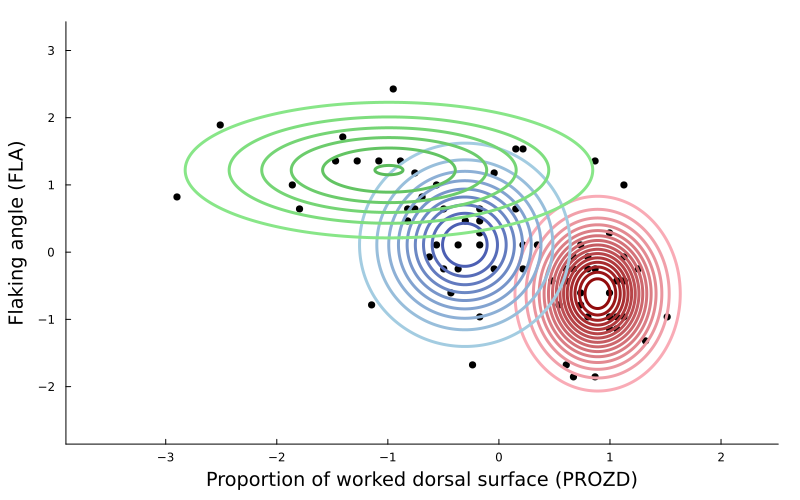

In [14]:
# Extract mixture weights
π_hat = mean(results.posteriors[:π][num_iters])

# Extract component means
μ_hat = mean.(results.posteriors[:μ][num_iters])

# Extract covariance matrices
Σ_hat = inv.(mean.(results.posteriors[:Λ][num_iters]))

# Select dimensions to plot
xlims = [minimum(data["observations"][:,1])-1, maximum(data["observations"][:,1])+1]
ylims = [minimum(data["observations"][:,2])-1, maximum(data["observations"][:,2])+1]

# Plot data and overlay estimated posterior probabilities
plot_clusters(data["observations"][:, 1:2], 
              μ=μ_hat, 
              Σ=Σ_hat, 
              xlims=xlims, 
              ylims=ylims,
              xlabel="Proportion of worked dorsal surface (PROZD)",
              ylabel="Flaking angle (FLA)",
              colors=[:reds, :blues, :greens],
              figsize=(800,500))

That doesn't look bad. The three Gaussians nicely cover all samples.

---

#### Exercise

Play around with the number of components. Can you get an equally good coverage with just 2 components? What if you had 4?

---

We can also plot the evolution of the parameters over iterations of the variational inference procedure.

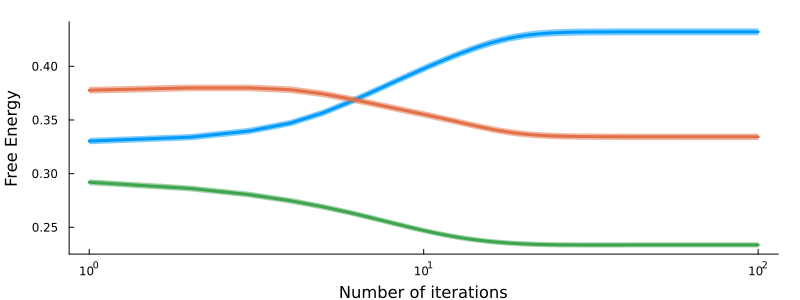

In [15]:
# Extract mean and standard deviation from 
mean_π_iters = cat(mean.(results.posteriors[:π])..., dims=2)
vars_π_iters = cat(var.( results.posteriors[:π])..., dims=2)

plot(1:num_iters, 
     mean_π_iters', 
     ribbon=vars_π_iters', 
     xscale=:log10,
     xlabel="Number of iterations", 
     ylabel="Free Energy", 
     size=(800,300))

---

#### Exercise

Plot the evolution of one of the component means over iterations of variational inference, including its variance.

---